In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from pytorch_pae import AE

In [3]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
print(torch.cuda.memory_allocated())
with torch.no_grad():
    AE1 = torch.load(os.path.join('/global/cscratch1/sd/vboehm/Models/Tutorials', 'AE_SDSS_1'))
print(torch.cuda.memory_allocated())

0
11176960


In [5]:
print(torch.cuda.memory_allocated()/1e9)
print(torch.cuda.max_memory_allocated()/1e9)

0.01117696
0.01117696


In [6]:
from torchsummary import summary

In [7]:
summary(AE1,(1,1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 957]           1,440
              ReLU-2              [-1, 32, 957]               0
 AdaptiveMaxPool1d-3              [-1, 32, 957]               0
           Flatten-4                [-1, 30624]               0
            Linear-5                   [-1, 10]         306,250
       ConvEncoder-6                   [-1, 10]               0
           Flatten-7                   [-1, 10]               0
            Linear-8                [-1, 30624]         336,864
           Reshape-9              [-1, 32, 957]               0
             ReLU-10              [-1, 32, 957]               0
         Upsample-11              [-1, 32, 957]               0
  ConvTranspose1d-12             [-1, 32, 1000]          45,088
  ConvTranspose1d-13              [-1, 1, 1000]              33
      ConvDecoder-14              [-1, 

In [8]:
AE1=AE1.float()

In [25]:
# RUN             = '1'
# EPOCHS          = 40

# seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

# conditional     = False
# cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
# root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
# root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
# root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
# min_SN          = 50
# min_z           = 0.05
# max_z           = 0.36
# label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
# label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
# label_2         = label_+'_10_fully_connected_mean_div_spec_norm'

# plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'

# if conditional:
#     label_2='conditional_%s'%cond_on+label_2
    
data_path       = '/global/cscratch1/sd/vboehm/SDSSOutlier/cnn_normed'

In [10]:
train = pickle.load(open(os.path.join(root_model_data,'SDSS_DR16_preprocessed_train.pkl'),'rb'))
valid = pickle.load(open(os.path.join(root_model_data,'SDSS_DR16_preprocessed_test.pkl'),'rb'))

In [11]:
torch.cuda.empty_cache()

In [12]:
encoded_train = []
for ii in range(10):
    num =len( train['spec'])//10
    with torch.no_grad():
        data          = torch.as_tensor(np.swapaxes(train['spec'][ii*num:(ii+1)*num],2,1)).to(device).detach().float()
        encoded_train+=[AE1.encoder.forward(data).detach().cpu().numpy()]
        del data
        torch.cuda.empty_cache()
        #print(torch.cuda.memory_allocated()/1e9)
if (len(train['spec'])%10)!=0:
    data          = torch.as_tensor(np.swapaxes(train['spec'][(ii+1)*num::],2,1)).to(device).detach().float()
    encoded_train+=[AE1.encoder.forward(data).detach().cpu().numpy()]
encoded_train = np.concatenate(encoded_train)

In [13]:
encoded_valid = []
for ii in range(10):
    num =len(valid['spec'])//10
    with torch.no_grad():
        data          = torch.as_tensor(np.swapaxes(valid['spec'][ii*num:(ii+1)*num],2,1)).to(device).detach().float()
        encoded_valid+=[AE1.encoder.forward(data).detach().cpu().numpy()]
        del data
        torch.cuda.empty_cache()
        #print(torch.cuda.memory_allocated()/1e9)
if (len(valid['spec'])%10)!=0:
    data          = torch.as_tensor(np.swapaxes(valid['spec'][(ii+1)*num::],2,1)).to(device).detach().float()
    encoded_valid+=[AE1.encoder.forward(data).detach().cpu().numpy()]
encoded_valid = np.concatenate(encoded_valid)

In [14]:
np.save(os.path.join(data_path,'encoded_cnn_normed.npy'),[encoded_train, encoded_valid])

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [15]:
decoded_train = []
for ii in range(10):
    num =len( train['spec'])//10
    with torch.no_grad():
        data          = torch.as_tensor(np.expand_dims(encoded_train[ii*num:(ii+1)*num],-1)).to(device).detach().float()
        decoded_train+=[AE1.decoder.forward(data).detach().cpu().numpy()]
        del data
        torch.cuda.empty_cache()

if (len(train['spec'])%10)!=0:
    data          = torch.as_tensor(np.expand_dims(encoded_train[(ii+1)*num::],-1)).to(device).detach().float()
    decoded_train+=[AE1.decoder.forward(data).detach().cpu().numpy()]
decoded_train = np.concatenate(decoded_train)

In [16]:
decoded_valid = []
for ii in range(10):
    num =len( train['spec'])//10
    with torch.no_grad():
        data          = torch.as_tensor(np.expand_dims(encoded_valid[ii*num:(ii+1)*num],-1)).to(device).detach().float()
        decoded_valid+=[AE1.decoder.forward(data).detach().cpu().numpy()]
        del data
        torch.cuda.empty_cache()

if (len(train['spec'])%10)!=0:
    data          = torch.as_tensor(np.expand_dims(encoded_valid[(ii+1)*num::],-1)).to(device).detach().float()
    decoded_valid+=[AE1.decoder.forward(data).detach().cpu().numpy()]
decoded_valid = np.concatenate(decoded_valid)

In [17]:
np.save(os.path.join(data_path,'decoded_cnn_normed.npy'),[ np.squeeze(decoded_train), np.squeeze(decoded_valid)])

In [23]:
def loss_by_wl(y_true, y_pred):
    loss           = (y_true[0]-y_pred)**2*y_true[2]*y_true[1]
    valid_loss     = np.mean(loss,axis=0)
    std_valid_loss = np.std(loss,axis=0)
    return valid_loss, std_valid_loss

In [24]:
loss = loss_by_wl((valid['spec'],valid['mask'],valid['noise']),np.expand_dims(np.squeeze(decoded_valid),-1))

In [26]:
wlmin, wlmax    = (3388,8318)
wl_range        = (np.log10(wlmin),np.log10(wlmax))
new_wl          = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

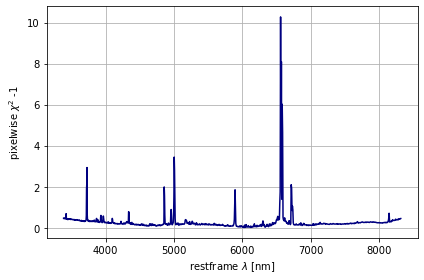

In [27]:
plt.plot(new_wl[:-1],loss[0]/np.mean(valid['mask'],axis=0)-1,color='navy')
plt.xlabel(r'restframe $\lambda$ [nm]')
plt.ylabel('pixelwise $\chi^2$ -1')
plt.grid()
plt.tight_layout()

In [28]:
print('mean reconstruction loss:', np.mean(loss[0]/np.mean(valid['mask'])))

mean reconstruction loss: 1.2804326844873437


In [29]:
np.save(os.path.join(data_path,'mean_loss_cnn_normed.npy'),loss[0])